Install dependencies

In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached gym-0.17.3-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.19.0
    Uninstalling gym-0.19.0:
      Successfully uninstalled gym-0.19.0


In [2]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import Video
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import sys
Running_in_colab = 'google.colab' in sys.modules

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

from PartI_lib import archs as archs
from PartI_lib import performance_evaluation as eval
from PartI_lib import train_loop as tl
from PartI_lib import my_tools as mt
# !mkdir Checkpoints
import time


True
cuda:0


In [3]:
#@title Deep RL Replay Buffer

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 20 consecutive trials.

In [4]:
#@title DQN movie generation (for visual evaluation in Google Colab)

def createMovie(Network,path,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env,path+'/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob(path+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        if(Running_in_colab):
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
        else:
            # print("Loc Video")
            # print(mp4)
            # print("VIDEO PR")
            Video(mp4)

            # HTML("""
            #         <video alt="test" controls>
            #             <source src="test.mp4" type="video/mp4">
            #         </video>
            #     """)
    else: 
        print("Could not find video")

In [5]:
# from IPython.display import HTML

# Video("openaigym.video.19.10825.video000000.mp4")
# HTML('<iframe width="560" height="315" src="openaigym.video.19.10825.video000000.mp4" frameborder="0" allowfullscreen></iframe>')

Run the new netwwork with random policy

In [6]:
# randomnet=RandomNet(2)
# createMovie(randomnet,"random")

Initialization and Parameters:


DQN_128_1_001_4e-03_099_1e-01_099
0 of 2000
11.0 11 11.0 11.0
30.0 30 20.5 20.5
44.0 44 23.428571428571427 23.428571428571427
45.0 45 24.5 24.5
61.0 61 26.42105263157895 26.42105263157895
25 of 2000
109.0 109 30.95 28.428571428571427
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000


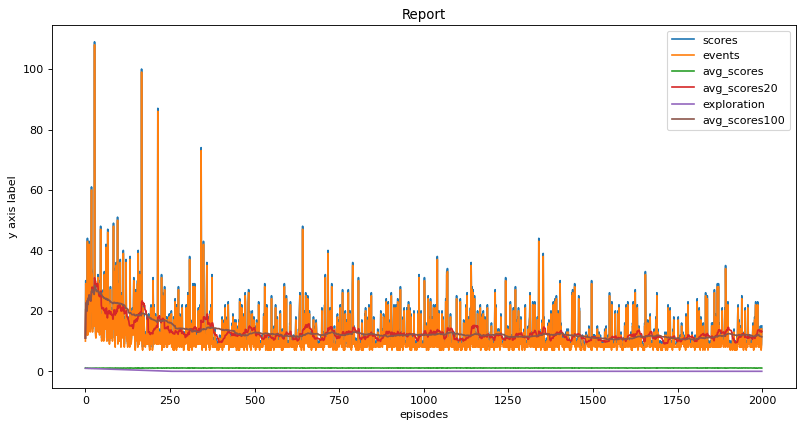

Could not find video
DQN_128_1_001_2e-02_099_1e-01_099
0 of 2000
27.0 27 27.0 27.0
46.0 46 31.333333333333332 31.333333333333332
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
55.0 55 13.0 11.69
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 2000
1675 of 2000
1700 of 2000
1725 of 20

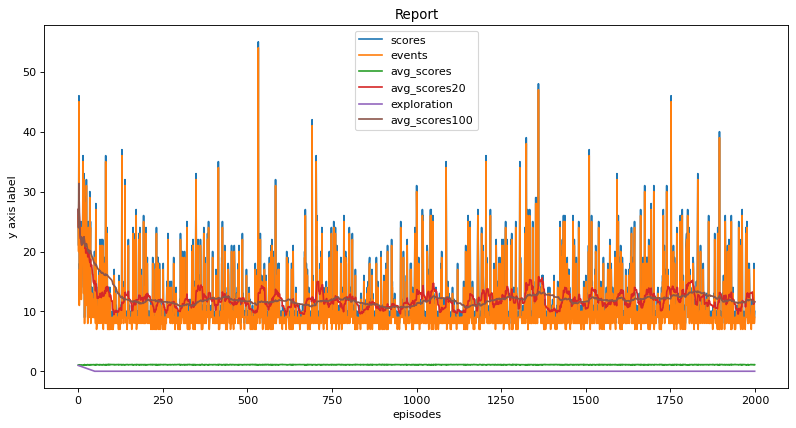

Could not find video
DQN_128_1_001_4e-03_099_1e-02_099
0 of 2000
27.0 27 27.0 27.0
27.0 27 22.8 22.8
29.0 29 23.142857142857142 23.142857142857142
36.0 36 23.583333333333332 23.583333333333332
37.0 37 23.61111111111111 23.61111111111111
25 of 2000
46.0 46 21.7 22.757575757575758
54.0 54 22.8 22.612244897959183
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000


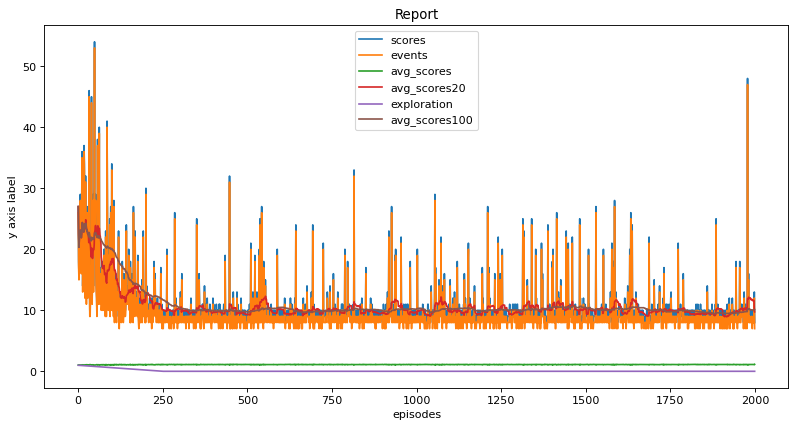

Could not find video
DQN_128_1_001_2e-02_099_1e-02_099
0 of 2000
25.0 25 25.0 25.0
26.0 26 21.333333333333332 21.333333333333332
44.0 44 23.875 23.875
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 2000
1675 of 2000
1700 of 2000
1725 of

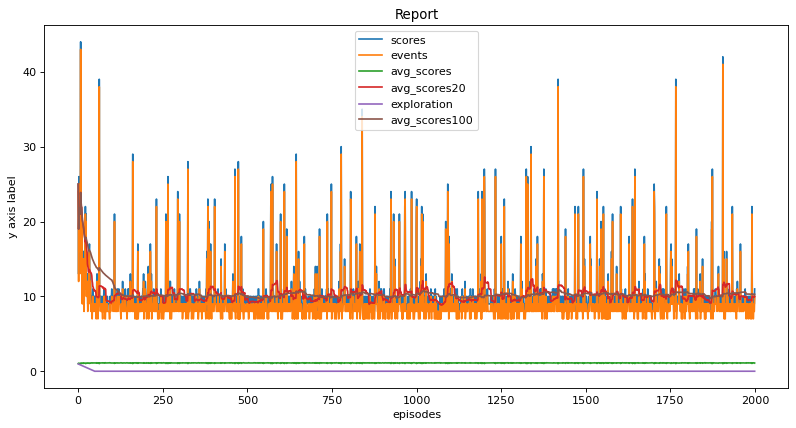

Could not find video
DQN_128_1_001_4e-03_099_1e-03_099
0 of 2000
10.0 10 10.0 10.0
10.0 10 9.666666666666666 9.666666666666666
13.0 13 10.5 10.5
34.0 34 15.2 15.2
47.0 47 21.0 21.0
25 of 2000
50.0 50 19.95 20.1875
80.0 80 22.45 21.941176470588236
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000


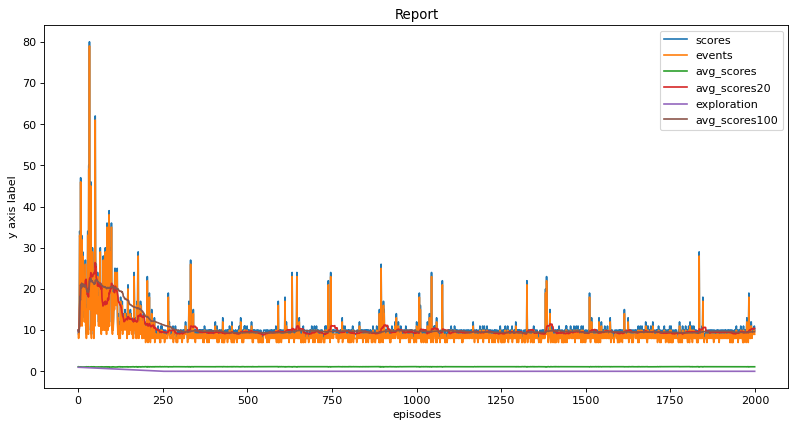

Could not find video
DQN_128_1_001_2e-02_099_1e-03_099
0 of 2000
14.0 14 14.0 14.0
55.0 55 34.5 34.5
60.0 60 30.285714285714285 30.285714285714285
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 2000
1675 of 2000
1700 of 2000
1725 of 200

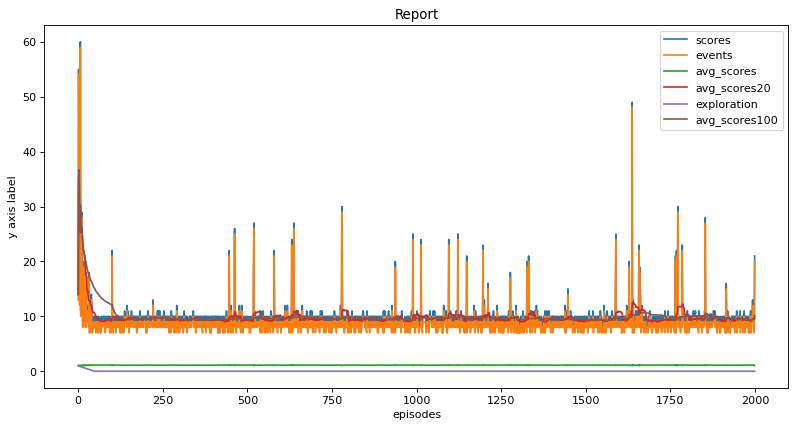

Could not find video
DuelingDQN_128_1_001_4e-03_099_1e-01_099
0 of 2000
8.0 8 8.0 8.0
20.0 20 14.0 14.0
22.0 22 14.2 14.2
41.0 41 17.666666666666668 17.666666666666668
25 of 2000
86.0 86 21.5 19.806451612903224
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 20

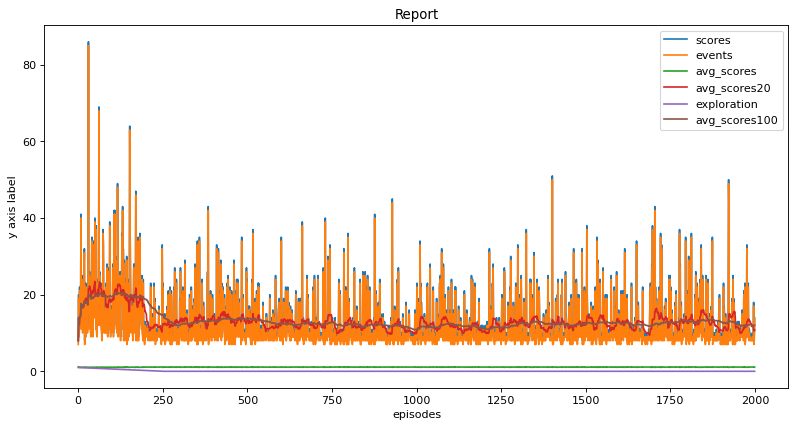

Could not find video
DuelingDQN_128_1_001_2e-02_099_1e-01_099
0 of 2000
19.0 19 19.0 19.0
23.0 23 17.333333333333332 17.333333333333332
31.0 31 20.75 20.75
40.0 40 18.65 18.47826086956522
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
43.0 43 13.55 12.89
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
53.0 53 13.8 13.16
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
55.0 55 13.35 12.54
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
58.0 58 14.4 13.06
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
62.0 62 14.35 12.42
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
14

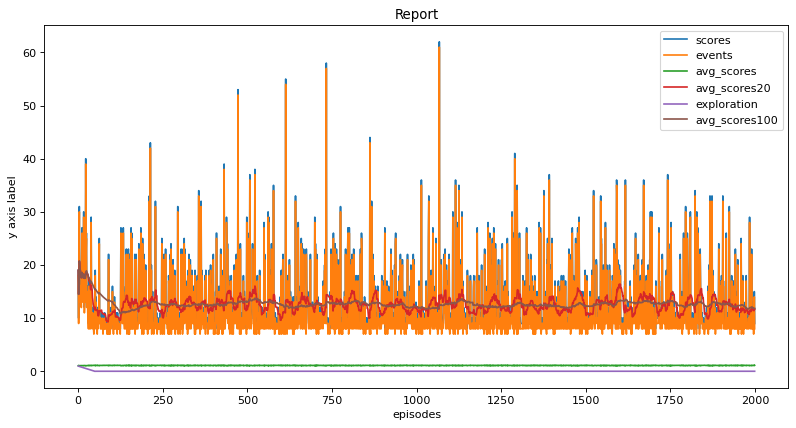

Could not find video
DuelingDQN_128_1_001_4e-03_099_1e-02_099
0 of 2000
28.0 28 28.0 28.0
32.0 32 22.7 22.7
60.0 60 22.666666666666668 22.666666666666668
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 2000
1675 of 2000
1700 of 2000
1725

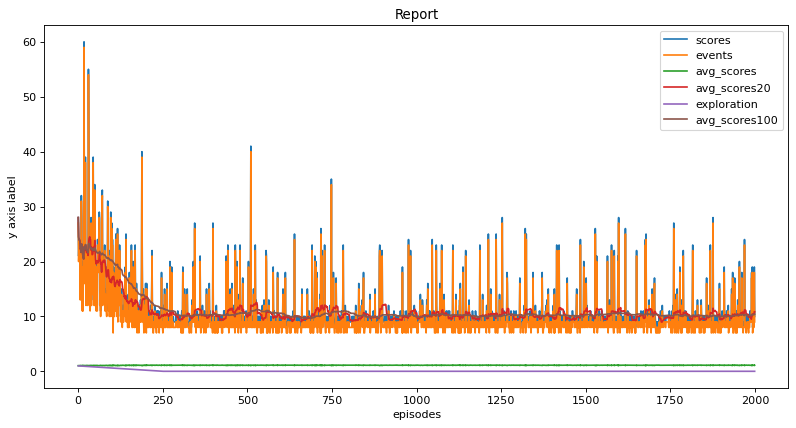

Could not find video
DuelingDQN_128_1_001_2e-02_099_1e-02_099
0 of 2000
22.0 22 22.0 22.0
29.0 29 25.5 25.5
33.0 33 28.0 28.0
36.0 36 25.571428571428573 25.571428571428573
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 2000
1675 of 2000

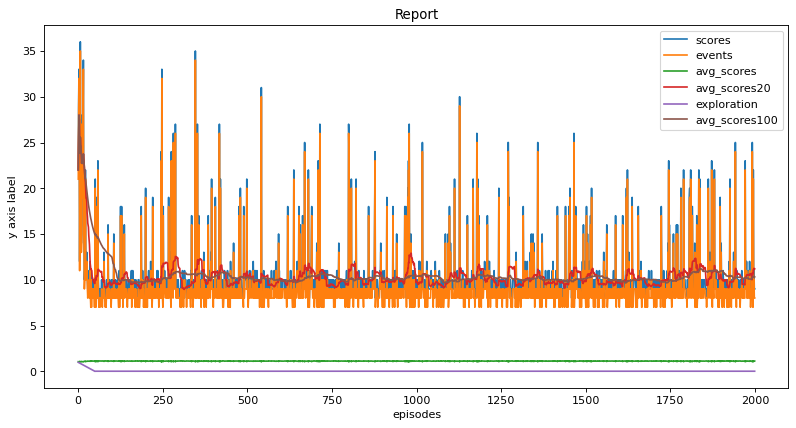

Could not find video
DuelingDQN_128_1_001_4e-03_099_1e-03_099
0 of 2000
24.0 24 24.0 24.0
28.0 28 23.333333333333332 23.333333333333332
28.0 28 23.6 23.6
33.0 33 24.0 24.0
39.0 39 25.1 25.1
48.0 48 24.928571428571427 24.928571428571427
58.0 58 25.705882352941178 25.705882352941178
75.0 75 27.1 26.952380952380953
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000


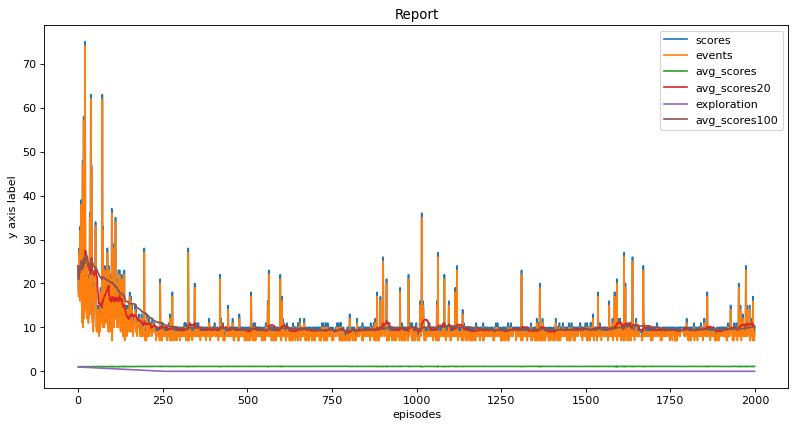

Could not find video
DuelingDQN_128_1_001_2e-02_099_1e-03_099
0 of 2000
24.0 24 24.0 24.0
25.0 25 23.25 23.25
29.0 29 20.875 20.875
31.0 31 22.0 22.0
25 of 2000
50 of 2000
75 of 2000
100 of 2000
125 of 2000
150 of 2000
175 of 2000
200 of 2000
225 of 2000
250 of 2000
275 of 2000
300 of 2000
325 of 2000
350 of 2000
375 of 2000
400 of 2000
425 of 2000
450 of 2000
475 of 2000
500 of 2000
525 of 2000
550 of 2000
575 of 2000
600 of 2000
625 of 2000
650 of 2000
675 of 2000
700 of 2000
725 of 2000
750 of 2000
775 of 2000
800 of 2000
825 of 2000
850 of 2000
875 of 2000
900 of 2000
925 of 2000
950 of 2000
975 of 2000
1000 of 2000
1025 of 2000
1050 of 2000
1075 of 2000
1100 of 2000
1125 of 2000
1150 of 2000
1175 of 2000
1200 of 2000
1225 of 2000
1250 of 2000
1275 of 2000
1300 of 2000
1325 of 2000
1350 of 2000
1375 of 2000
1400 of 2000
1425 of 2000
1450 of 2000
1475 of 2000
1500 of 2000
1525 of 2000
1550 of 2000
1575 of 2000
1600 of 2000
1625 of 2000
1650 of 2000
1675 of 2000
1700 of 2000
1725 of 

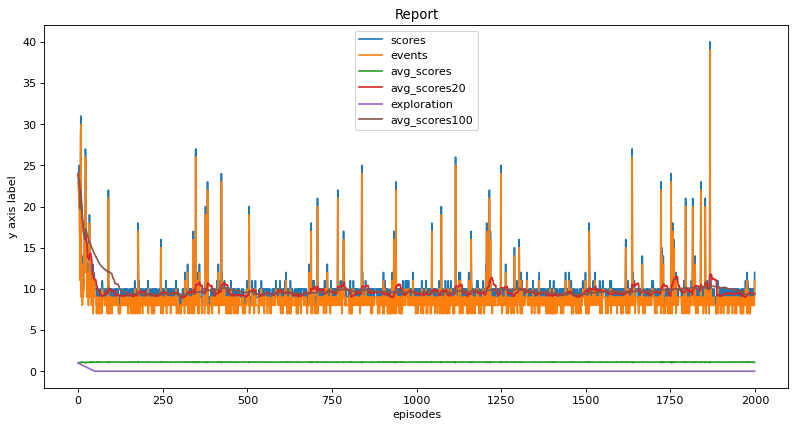

Could not find video


In [7]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")



inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=2000
MaxSteps=400
FreezeCounter=25
BatchSize=128
exploration_threshold=1
exploration_threshold_min=0.01
# exploration_decay=0.002
discount_factor=0.99
SaveAtCounter=200
LearningRateDecay=0.99


# arch = "DQN"

#network DQN


buffer = ReplayBuffer(1000000, inputs,device);

# print(policy_net)
for arch in ["DQN","DuelingDQN"]:
    file_path__ = mt.create_dir("results",arch)
    for n_layers in [3]:#,1,3]:
        policy_net, target_net = archs.archs(arch,inputs,n_actions,discount_factor,device,n_layers)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
        file_path_ = mt.create_dir(file_path__,"N"+str(n_layers)+"_Layers")
        for LearningRate in [0.1,0.01,0.001]:
            for exploration_decay in [0.004,0.02]:
                optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
                scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=LearningRateDecay)
                loss = torch.nn.MSELoss()
                def trainModel():
                    if buffer.counter < BatchSize:
                        return 0.0
                    
                    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

                    q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
                    with torch.no_grad():
                        q_max_next = target_net(new_state_batch).max(1)[0].detach()
                    q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

                    ll=loss(q_actual, q_target.unsqueeze(1))

                    # Optimize the model
                    optimizer.zero_grad()
                    ll.backward()
                    for param in policy_net.parameters():
                        param.grad.data.clamp_(-1, 1)
                    optimizer.step()

                    return ll.item();
                file_name = mt.set_name(arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,LearningRate,LearningRateDecay)
                file_path = mt.create_dir(file_path_,file_name)
                mt.create_dir(file_path,"Checkpoints")
                print(file_name)
                bestNet, episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100 = tl.train_loop(policy_net, target_net, env, device, TotalEpisodes, FreezeCounter, SaveAtCounter, createMovie, MaxSteps, exploration_threshold, exploration_decay, exploration_threshold_min, buffer, trainModel,file_path)

                eval.performance_evaluation(file_path,episodes, scores, events, avg_scores, avg_scores20, exploration, avg_scores100)
                eval.report(file_path,arch,BatchSize,exploration_threshold,exploration_threshold_min,exploration_decay,discount_factor,
                            LearningRate,LearningRateDecay,episodes, scores, events, avg_scores, avg_scores20, exploration, n_layers,avg_scores100)
                createMovie(bestNet,file_path,'bestNet')
                time.sleep(1)